In [10]:
# Calculate different clustering methods
import networkx as nx
import pandas as pd

G = nx.read_graphml("network.graphml")
threshold = 0.6

# Create a filtered graph
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]

network = nx.Graph()
network.add_edges_from(filtered_edges)

# Clustering analysis


In [12]:

from collections import defaultdict

# Get different clustering partitions
louvain_communities = nx.community.louvain_communities(network)
label_propagation = nx.community.label_propagation_communities(network)
greedy_modularity = nx.community.greedy_modularity_communities(network)

# Create a dictionary to store clusters and their nodes
clustering_results = {
    'louvain': list(louvain_communities),
    'label_propagation': list(label_propagation),
    'greedy_modularity': list(greedy_modularity)
}



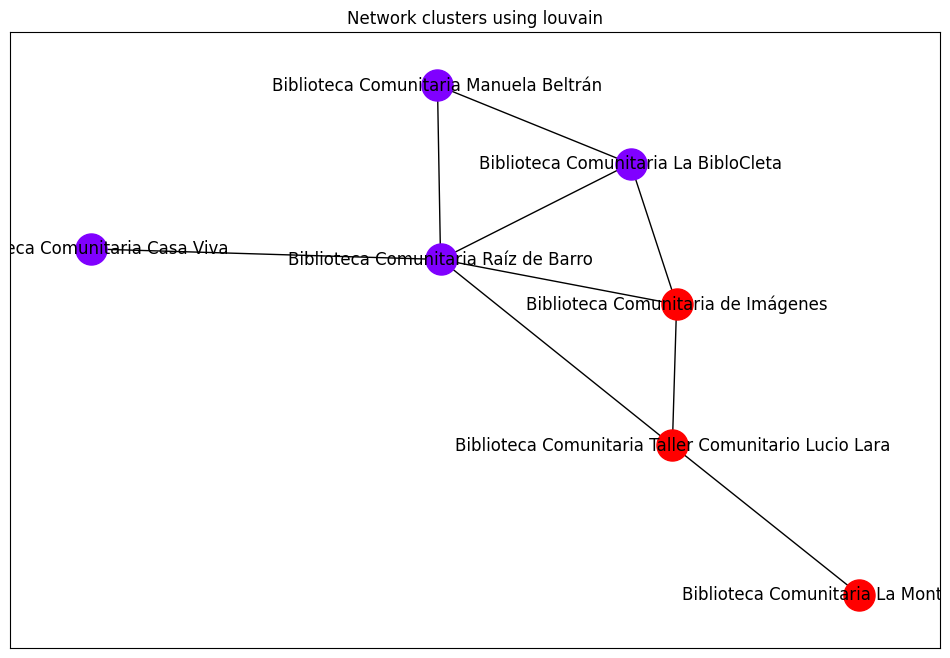

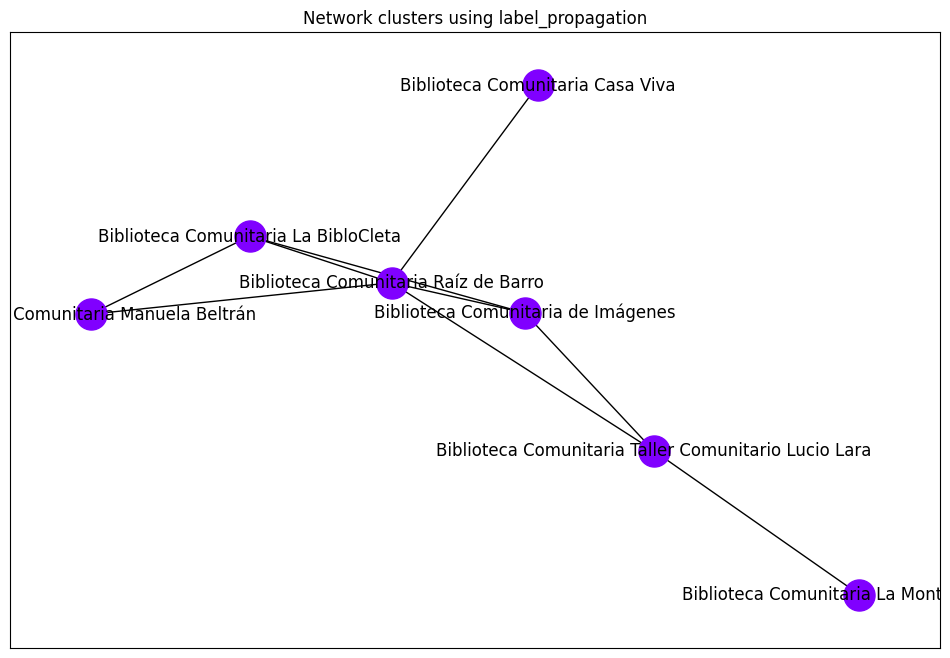

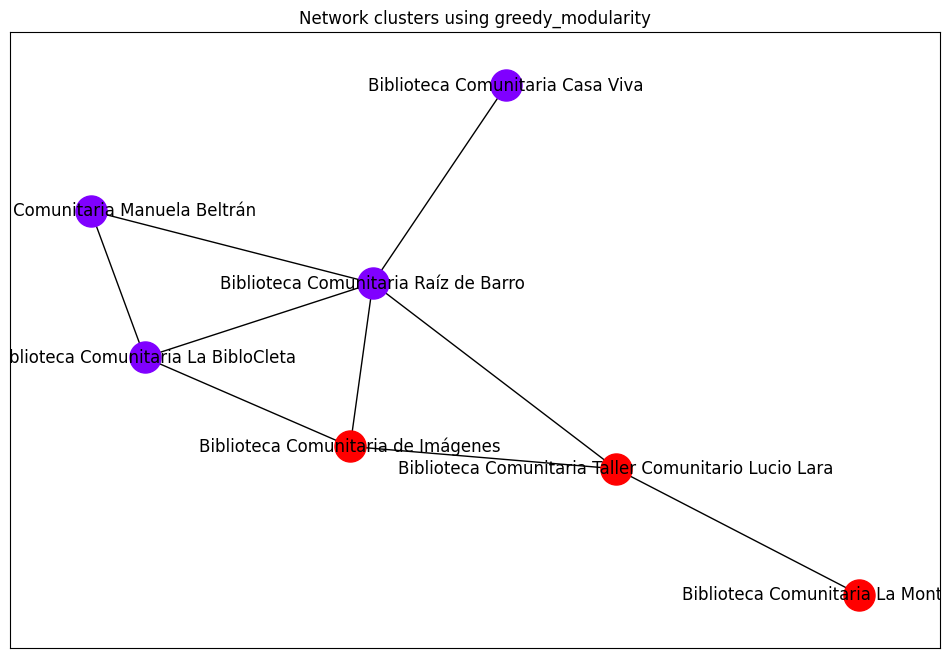

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_cluster_attributes(cluster, df):
    # Get subset of dataframe for cluster nodes
    cluster_df = df[df['BibliotecaNombre'].isin(cluster)]

    # Calculate statistics for numerical columns
    stats = cluster_df.describe()

    # Get mode for categorical columns
    categorical_stats = cluster_df.mode().iloc[0]

    return stats, categorical_stats


def draw_clustered_network(G, clusters, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)

    # Assign colors to clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

    for cluster, color in zip(clusters, colors):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=cluster,
                               node_color=[color],
                               node_size=500)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)
    plt.show()

df = pd.read_csv("..\output\\results.csv")

# Analyze each clustering method
cluster_analysis = defaultdict(dict)
for method, clusters in clustering_results.items():
    for i, cluster in enumerate(clusters):
        stats, cat_stats = analyze_cluster_attributes(cluster, df)
        cluster_analysis[method][f'cluster_{i}'] = {
            'nodes': list(cluster),
            'size': len(cluster),
            'numerical_stats': stats,
            'categorical_stats': cat_stats
        }


# Visualize each clustering method
for method, clusters in clustering_results.items():
    draw_clustered_network(network, clusters, f'Network clusters using {method}')


In [ ]:

# Analysis of Clusters
clustering_results
df_encuestas = pd.read_csv("../data/Contacto Bibliotecas - Formulario Coordenadas.csv")
df_categorias = pd.read_csv("../data/Contacto Bibliotecas - Coordenadas de Analísis.csv")
df_encuestas
# Explicación de los clusters
import openai
import pandas as pd

client = openai.OpenAI()


# Supongamos que ya tienes df_encuestas y df_categorias cargados

def construir_prompt(df_cluster, df_categorias, df_encuestas):
    prompt = "Analiza las siguientes bibliotecas y explica en qué son similares en términos de las categorías de análisis proporcionadas:\n\n"

    # Añadir información de las bibliotecas
    for idx, row in df_cluster.iterrows():
        prompt += f"Biblioteca: {row['Nombre de la biblioteca comunitaria']}\n"
        for idx_cat, cat_row in df_categorias.iterrows():
            categoria = cat_row['Nombre columna']
            descripcion = cat_row['Descripción']
            valor = row.get(categoria, 'No disponible')
            prompt += f"- {descripcion}: {valor}\n"
        prompt += "\n"

    # Añadir instrucciones específicas
    prompt += "Basándote en la información anterior, describe las similitudes entre estas bibliotecas en español."
    return prompt


def analizar_cluster(cluster, df_surveys, df_categories):
    # Filter the libraries in the cluster
    libraries = list(cluster)
    df_cluster = df_surveys[df_surveys['Nombre de la biblioteca comunitaria'].isin(libraries)]

    # Build the prompt
    prompt = construir_prompt(df_cluster, df_categories)

    # Call the OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un analista de datos especializado en bibliotecas comunitarias."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1000,
        temperature=0.7,
    )

    # Extract the analysis
    analysis = response.choices[0].message.content.strip()
    return analysis


clusters = clustering_results

for algoritmo, lista_clusters in clusters.items():
    print(f"Análisis para el algoritmo: {algoritmo}\n")
    for idx, cluster in enumerate(lista_clusters):
        analisis = analizar_cluster(cluster, df_encuestas, df_categorias)
        print(f"Cluster {idx + 1}:\n{analisis}\n")
        break
    break